# Data Exploration

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train = df_train.dropna()
df_train["loan_int_rate"] = df_train["loan_int_rate"] / 100

# make a copy to use and view that data
df_ = df_train.copy()
df_

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,27,98000,RENT,3.0,EDUCATION,C,11750,0.1347,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,0.0751,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,0.1287,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,0.0963,0,0.28,N,10
6,21,21700,RENT,2.0,HOMEIMPROVEMENT,D,5500,0.1491,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,0.0729,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,0.0542,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,0.1171,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,0.1268,0,0.24,N,8


Lets explore how loan intent varies across age groups

Text(0.5, 1.0, 'Loan Intent by Age')

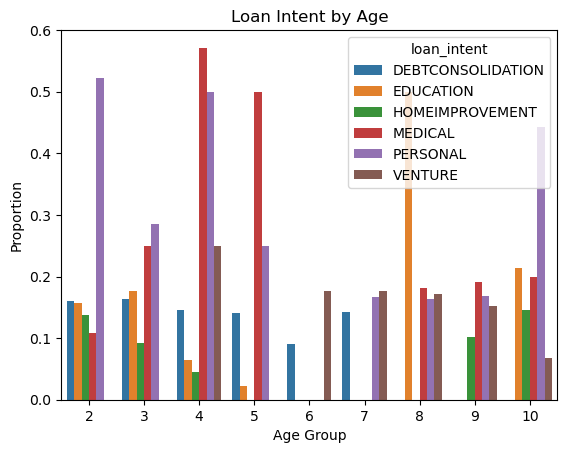

In [3]:
# first lets add a column for age groups
df_["age_group"] = df_["person_age"] // 10
df_["age_group"][df_["age_group"] >= 10 ] = 10

# Get the counts of each loan intent within each age group
loan_intent_counts = df_.groupby("age_group")["loan_intent"].value_counts().unstack()
loan_intent_counts = loan_intent_counts.fillna(0)

# Convert counts to proportions relative to each age group
loan_intent_prop = loan_intent_counts.div(loan_intent_counts.sum(axis=1), axis=0)

# visualize the trends of loan intent and age
temp = pd.melt(loan_intent_prop)

temp["age_group"] = 0 # rebuild the age group category
for i in range(0, len(temp) + 1):
  temp["age_group"][i] = (i % 9) + 2

ax = sns.barplot(data = temp, x = "age_group", y = "value", hue = "loan_intent")
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion")
ax.set_title("Loan Intent by Age")

The chart indicates that personal loans are most common among individuals aged 20-29, 40-49, and 90-99, suggesting a consistent need for general-purpose borrowing across different life stages. Medical loans peak in the 40-49 and 50-59 age groups, likely due to increasing healthcare expenses. Education loans spike in the 70-79 age group, which may indicate late-stage career shifts or funding for dependents. Debt consolidation loans are relatively steady, with moderate representation in the 30-39, 50-59, and 60-69 age groups. Home improvement loans have lower proportions overall but see slight increases among borrowers aged 20-29 and 80-89. Venture loans are sporadic, with small peaks in the 50-59 and 60-69 age groups, possibly reflecting mid-life entrepreneurial activity. These trends highlight how borrowing needs evolve across different age brackets.

In [4]:
df_2 = df_train.copy()
df_2["income_cat"] = df_2["person_income"] // 100000

print(df_2.groupby("income_cat")["loan_amnt"].mean().round())

income_cat
0      8892.0
1     13697.0
2     17380.0
3     18896.0
4     18670.0
5     15136.0
6     17267.0
7     13192.0
9     19150.0
12    10000.0
13     6600.0
14     6400.0
20     8450.0
60     5000.0
Name: loan_amnt, dtype: float64


While salary (income category) does seem to affect the loan amount, with people having higher salaries taking out larger loans, the higher income categories actually often have lower loan amounts than the lower income categories. This may be a product of people making larger salaries not needing to take out loans as frequently as the middle salaries, which can afford to take out larger loans and pay them back. Let's also determine what factors seem to be related to higher interest rates.

In [5]:
print(df_train.groupby(["loan_int_rate", "loan_grade"]).size())

loan_int_rate  loan_grade
0.0542         A             443
0.0579         A             289
0.0599         A             284
0.0600         A               1
               B               3
                            ... 
0.2136         F               4
0.2174         F               2
0.2211         G               2
0.2248         G               1
0.2322         G               1
Length: 371, dtype: int64


From this snapshot of the larger table, it seems that the high grade loans are associated with the lowest interest rates. Lets explore factors related to loan grades by grouping.

In [6]:
temp = df_train.groupby("loan_grade")[["person_income", "loan_percent_income", "loan_amnt"]].mean()

print(temp)

            person_income  loan_percent_income     loan_amnt
loan_grade                                                  
A            66773.007816             0.152629   8555.884885
B            66662.091096             0.173846  10031.025007
C            66416.633130             0.168928   9322.102794
D            64555.473908             0.188833  10821.646695
E            70868.349432             0.204190  12929.083807
F            80756.546012             0.220982  15395.705521
G            77342.477273             0.243409  17384.659091


As we can see from this datatable, loan grade is directly correlated with lower percent of total income. Meaning that higher quality loans, with lower interest rates are associated with loaners whose loan takes up the smallest percent of their total income. This is likely related to the loan taking up a lower percent of their income making it less likely for them to default on the loan. It also seems to follow that people with higher income tend to take out larger loans.

<Axes: xlabel='person_income', ylabel='loan_amnt'>

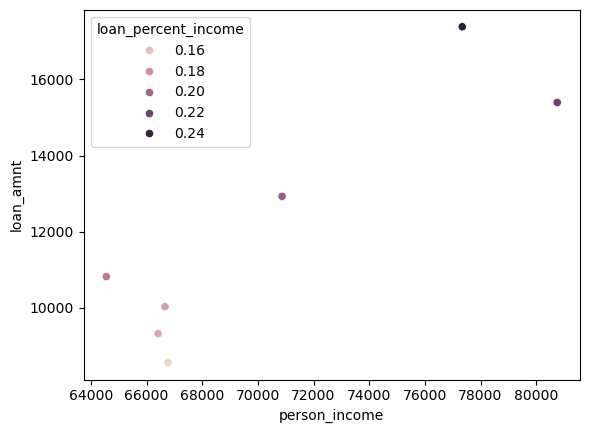

In [7]:
sns.scatterplot(data = temp, x = temp["person_income"], y = "loan_amnt", hue = "loan_percent_income", legend = "brief")

Lower income tends to result in smaller loans, which also take up less percent of loaners total income. The darker shades representing higher percent of total income are associated with lower quality loans. Higher quality loans are assesed to be more likely to repay the loan instead of defaulting.

# Feature Selection & Weight Assessment

Select the predictor and target variables related to loan grade.

In [8]:
from sklearn.model_selection import train_test_split

# select the predictor variables identified with loan grade. Also the include the loaners default history
predictor_cols = ["person_income", "loan_amnt", "loan_percent_income", "loan_int_rate", "cb_person_default_on_file"]
X_model = df_train[predictor_cols].copy()  # Use .copy() to avoid modifying the original DataFrame

# target variable selection
y_model = np.array(df_train["loan_status"])

# Create binary indicators for past defaults
X_model["past_default_yes"] = X_model["cb_person_default_on_file"] == "Y"
X_model["past_default_no"] = X_model["cb_person_default_on_file"] == "N"

# Generate weighted default predictor
X_model["weighted_default"] = X_model["loan_percent_income"] * (1 +  X_model["past_default_yes"])

# Generate weigthed interest rate predictor
X_model["weighted_interest"] = (1 + X_model["loan_int_rate"]) * X_model["loan_amnt"] * (1 + X_model["past_default_yes"])

# Drop the original categorical column
X_model.drop("cb_person_default_on_file", axis=1, inplace=True)

# Breaking into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2)

Fit a Linear Regression model to the data and assess its accuracy of prediction. Try all combinations of predictors. Once a good model is fit, pull out the weight coefficient to use for a linear score based classifier.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.metrics import accuracy_score

numerical_predictors = ["person_income", "loan_amnt", "loan_percent_income", "loan_int_rate", "weighted_default", "weighted_interest"]
qual_predictors = ["past_default_yes", "past_default_no"]
predictor_cols = numerical_predictors + qual_predictors

results = []

# compute the best combinations
for r in range(1, len(predictor_cols) + 1):  # From 1 feature to all features
    for subset in combinations(predictor_cols, r):
        test_cols = list(subset)
        
        # Select subset of features
        X_train_subset = X_train[test_cols]
        X_test_subset = X_test[test_cols]
        
        # Train a simple logistic regression model
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_subset, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test_subset)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store results
        results.append({"features": test_cols, "accuracy": accuracy})

From the list of feature combinations, pull out the top 5 and retest them against the premade training and testing data. Once the best from this list has been identified, verify its accuracy with cross validation to check for overfitting. If the features pass, pull out the weights coefficient to use for a linear score based classifier. 

In [10]:
# select the top results by accuracy
best_features = pd.DataFrame(results).sort_values(by = "accuracy", ascending = False).head(5)["features"].tolist()

true_predictors = []
best_acc = 0

for features in best_features:
    # fit a model to the feature list
    LR_test = LogisticRegression()
    m_test = LR_test.fit(X_train[features], y_train)

    y_pred = LR_test.predict(X_test[features])
    acc = accuracy_score(y_test, y_pred)

    if acc > best_acc:
        best_acc = acc
        true_predictors = features

print("The predictors with the highest testing accuracy are: " + str(true_predictors) + "\nAccuracy = " + str(best_acc))

# Check with cross validation
LR_real = LogisticRegression()
m_real = LR_real.fit(X_train[true_predictors], y_train)

cv_scores_LR = cross_val_score(LR_real, X_test[true_predictors], y_test, cv = 5)

print("Cross validation for the selected predictors: " + str(cv_scores_LR))

# store the weight coefficients for this model to build our linear score function
w = m_real.coef_
s = w.shape
w = w.reshape(s[1], s[0])

The predictors with the highest testing accuracy are: ['loan_amnt', 'loan_percent_income']
Accuracy = 0.8197293758184199
Cross validation for the selected predictors: [0.81461287 0.81352236 0.81222707 0.80895197 0.81004367]


Upon inspecting accuracy versus the overall test set income the predictors above were selected as the best variables based purely on accuracy. These predictors also had reasonable cross validation scores that were similar to the overall testing accuracy; this implies that the model is consisent and not overfit. The weight constants from this model were then pulled out and stored for later used in a linear score function. 

# Optimizing a Linear Score Classification

Start by defining our linear score function using our weight vector and our classification function with an arbitrary starting threshold. We will then optimize this threshold such that the bank makes the largest possible profit per loan.

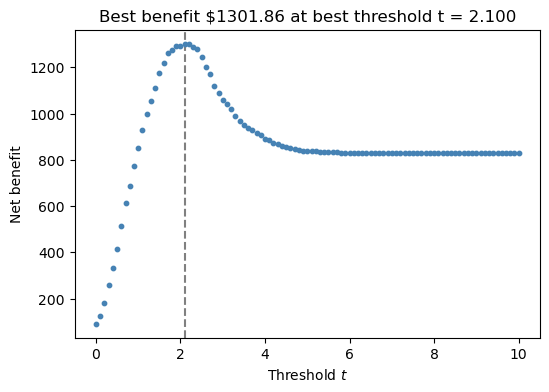

In [11]:
from matplotlib import pyplot as plt

# Performs the dot product between the data vector X and the weight vector w
def score(X, w):
    return np.dot(X,w)

# Returns the predictions of the model. 1 if the loaner is predicted to default, and 0 if they are predicted to repay the loan
def predict(score, threshold, df):
  scores = score(df, w)
  return 1*(scores > threshold)

# pull out model data
X_model = X_train.copy()

# initialize the benefit column
X_model["benefit"] = 0

best_benefit = 0
best_threshold = 0

scores = score(X_model[true_predictors], w)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for t in np.linspace(0, 10, 101):
    X_model["y_pred"] = scores >= t

    X_model["tn"] = (X_model["y_pred"] == 0) & (y_train == 0)
    X_model["fn"] = (X_model["y_pred"] == 0) & (y_train == 1)
    
    X_model["benefit"][X_model["tn"]] = X_model["loan_amnt"] * (1 + 0.25 * X_model["loan_int_rate"]) ** 10 - X_model["loan_amnt"]
    X_model["benefit"][X_model["fn"]] = X_model["loan_amnt"] * (1 + 0.25 * X_model["loan_int_rate"]) ** 3 - 1.7 * X_model["loan_amnt"]

    average_benefit = np.sum(X_model["benefit"]) / len(X_model)

    ax.scatter(t, average_benefit, color = "steelblue", s = 10)
    if average_benefit > best_benefit:
        best_benefit = average_benefit
        best_threshold = t

ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Net benefit", title = f"Best benefit ${best_benefit:.2f} at best threshold t = {best_threshold:.3f}")

Maximization of the bank's profit results in a threshold of 2.1, with a profit per buyer of $1301.86. The value of the threshold has been stored for later use. Lets now test the model with our optimal weight vector and threshold against new testing data. 

In [12]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

df_test = df_test.dropna()
df_test["loan_int_rate"] = df_test["loan_int_rate"]  /100

# Create binary indicators for past defaults
df_test["past_default_yes"] = df_test["cb_person_default_on_file"] == "Y"
df_test["past_default_no"] = df_test["cb_person_default_on_file"] == "N"

# Generate weighted default predictor
df_test["weighted_default"] = df_test["loan_percent_income"] * (1 +  df_test["past_default_yes"])

# Generate weigthed interest rate predictor
df_test["weighted_interest"] = (1 + df_test["loan_int_rate"]) * df_test["loan_amnt"] * (1 + df_test["past_default_yes"])

# Drop the original categorical column
df_test.drop("cb_person_default_on_file", axis=1, inplace=True)

# initialize the benefit column
df_test["benefit"] = 0

# calculate the score array and the expected profit per buyer
scores = score(df_test[true_predictors],w)

df_test["y_pred"] = scores >= best_threshold

df_test["tn"] = (df_test["y_pred"] == 0) & (df_test["loan_status"] == 0)    
df_test["fn"] = (df_test["y_pred"] == 0) & (df_test["loan_status"] == 1)
    
df_test["benefit"][df_test["tn"]] = df_test["loan_amnt"] * (1 + 0.25 * df_test["loan_int_rate"]) ** 10 - df_test["loan_amnt"]
df_test["benefit"][df_test["fn"]] = df_test["loan_amnt"] * (1 + 0.25 * df_test["loan_int_rate"]) ** 3 - 1.7 * df_test["loan_amnt"]

average_benefit = np.sum(df_test["benefit"]) / len(df_test)
print("The expected profit per buyer is: $" + str(round(average_benefit, 2)))

The expected profit per buyer is: $1227.71


The expected profit per buyer on the test set ($1301.86) is only slightly lower than the expected profit per buyer on the training set ($1227.71). Thus our model was able to generalize from the training set. 

# Evaluating Model Fairness

Lets explore if some loaners are more or less likely to receive loans based on their age

In [ ]:
# remake age groups in 10 year gaps and calculate the difference in default prediction vs reality
df_test["age_group"] = df_test["person_age"] // 10
df_test["diff"] = df_test["y_pred"] - df_test["loan_status"]

# Display this data as a table
temp = df_test.groupby("age_group")[["loan_status", "y_pred", "diff"]].mean().reset_index()
temp

,age_group,loan_status,y_pred,diff
0,2,0.228689,0.163246,-0.065443
1,3,0.204082,0.136578,-0.067504
2,4,0.200000,0.138462,-0.061538
3,5,0.261905,0.119048,-0.142857
4,6,0.500000,0.333333,-0.166667
5,7,0.500000,0.500000,0.000000


In almost all age groups (age group 7 only has two individuals) the algorithm underpredicts the loan default rate. However, two age groups which are far less likely to get a loan than other groups (excluding group 7), are age group 20-29 and 60-69. Despite, the algorithim underpredicting the default rate in this age group, especially in the 60-69 age group, these groups are still predicted to be much more likely to defualt than the other age groups. Lets now look at the difficulty of getting loans based on loan intent.

<Axes: xlabel='Proportion of Loan Status', ylabel='loan_intent'>

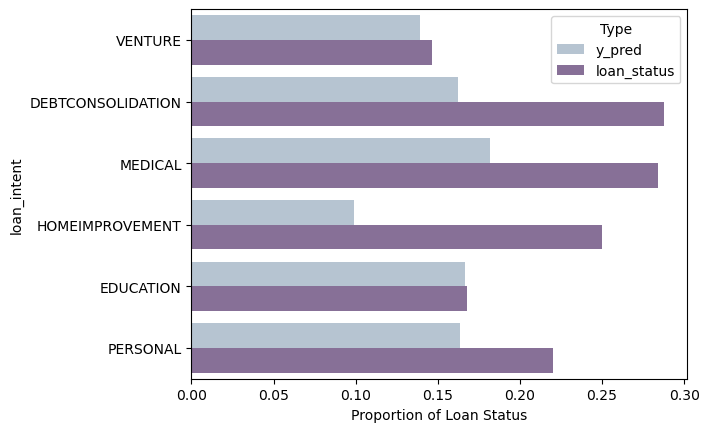

In [58]:
temp2 = df_test.copy()

# Melt the data so it can be plotted in a
temp2_melted = pd.melt(temp2, id_vars = "loan_intent", value_vars = ["y_pred", "loan_status"], var_name = "Type", value_name = "Proportion of Loan Status")

sns.barplot(data = temp2_melted, y = "loan_intent", x = "Proportion of Loan Status", hue = "Type", palette = "BuPu", saturation = 0.5, orient = "h", errorbar = None)

Medical loans have the highest predicted default rate making them the hardes loans to get, however medical loans do have the second highest default rate. Education, Personal, and Debt Consolidation are the next hardest loans to get. Venture loans are predicted to default less often than the previous, and Home Improvement loans are predicted to default the least, despite having the third highest actual default rate. In all cases, the default rate was predicted to be less than than it ended up being. Now, lets examine how gross income affects the ease with which credit can be obtained. 

<Axes: xlabel='income_group', ylabel='Proportion of Loan Status'>

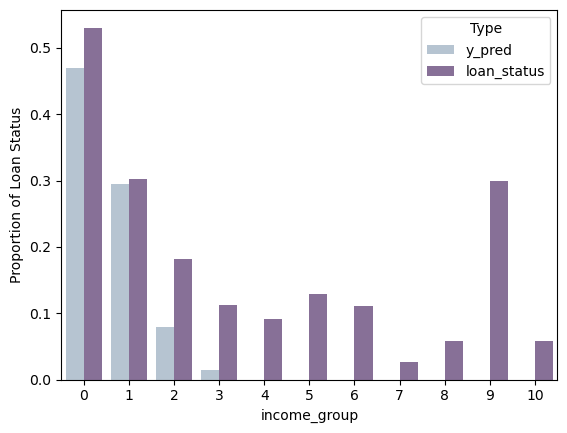

In [60]:
temp3 = df_test.copy()

# Group income into categories separated by $25,000 in income
temp3["income_group"] = temp3["person_income"] // 25000
temp3["income_group"][temp3["income_group"] >= 10 ] = 10

# Melt the data so it can be plotted in a bar plot
temp3_melted = pd.melt(temp3, id_vars = "income_group", value_vars = ["y_pred", "loan_status"], var_name = "Type", value_name = "Proportion of Loan Status")

sns.barplot(data = temp3_melted, x = "income_group", y = "Proportion of Loan Status", hue = "Type", palette = "BuPu", saturation = 0.5, errorbar = None)

In this model, lower income is strongly associated with greater likelihood to default, making it much harder get loans at low income. While lower income is generally associated with higher default rates, it is unrealistic that the model predicts loaners making more than $75,000 to pay back their loans 100% of the time. In fact, the second highest default rate is actually in the $200,000 - $224,999 income category.